In [1]:
# Проверка возможности использования xgbooster - объединение JPG & TIF (2017-07-03)

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
import xgboost as xgb

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [7]:
binsData = 75

trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
if False : # True :
    trDirI = trDirJPG
    teDirI = teDirJPG
    ttExt  = '.jpg'
else :
    trDirI = trDirTIF
    teDirI = teDirTIF
    ttExt  = '.tif'
trWork, teWork = '../Work/Train', '../Work/Test'
print (trDirI,teDirI, trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Data/train-tif-v2 ../Data/test-tif-v2 ../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [67]:
binsDataTIF = 96
binsDataJPG = 96

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
#labelList[:6,:]
#labels_df.head()

In [119]:
# Данные для объединения от jpg
trX_TIF = np.load('../Work/train-data-XX'+str(binsDataTIF)+'.tif'+'.npy')
trX_JPG = np.load('../Work/train-data-XX'+str(binsDataJPG)+'.jpg'+'.npy')
trY     = np.load('../Work/train-data-YY'+str(binsDataTIF)+'.tif'+'.npy')
trX_TIF.shape, trX_JPG.shape

((40479, 578), (40479, 255))

In [120]:
578/6, 255/3, 96+96+96

(96, 85, 288)

In [121]:
# Обрезка видимой части и использование только n, nvi, dwi
trX_TIF = trX_TIF[:,288:]

In [122]:
trX_TIF.shape, 290/3

((40479, 290), 96)

In [123]:
trXX = np.hstack([trX_JPG,trX_TIF])
trX  = trXX
print (trX.shape,trX_TIF.shape,trX_JPG.shape,trY.shape)
del trXX,trX_JPG,trX_TIF

(40479, 545) (40479, 290) (40479, 255) (40479, 17)


In [124]:
# Строим основные массивы
dtrain = xgb.DMatrix(trX,label=trY[:,0])

In [125]:
# Построение списка bst - моделей
def getListBST (param, trX, trY, nfold=3, early_stop=20) :
    dtrain = xgb.DMatrix(trX,label=trY[:,0])
    results, bstList = [], []
    for i in range(trY.shape[1]) :
        print ('Working: {}'.format(i))
        dtrain.set_label(trY[:,i])
        history = xgb.cv(param, dtrain, metrics=['auc'], 
                         verbose_eval=30, num_boost_round=5000, nfold=nfold, 
                         early_stopping_rounds=early_stop)
        results.append(history)
        rvalidCV, watchlistCV = {}, [(dtrain,'train')]
        bst = xgb.train(param, dtrain, history['test-auc-mean'].argmax()+1, watchlistCV) 
        bstList.append(bst)
    return(bstList)

# Построение решения по dmatrix и bst списку
def buildPredict (dData, bstList) :
    trYP = []
    for bstI in bstList :
        trYP1 = bstI.predict(dData); trYP.append(trYP1)
    trYP = np.array(trYP).T
    #type(trYP),trYP.shape
    return(trYP)

# Построение решения по np.array (DataFrame?) и bst списку
def buildPredictX (Data, bstList) :
    dData = xgb.DMatrix(Data);
    return (buildPredict(dData,bstList))

In [126]:
# Процедуры для оценки результативности

def getConfusion (tGroundTrue, tPredict) :
    cList = []
    for i in range(tPredict.shape[1]) :
        cList.append(skm.confusion_matrix(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(cList))

def getRocAUC (tGroundTrue, tPredict) :
    rList = []
    for i in range(tPredict.shape[1]) :
        rList.append(skm.roc_auc_score(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(rList))

In [127]:
# Оценка нескольких наборов
def getProb01 (trYP, th=0.5) :
    trYY = trYP.copy()
    trYY[trYY<th] = 0
    trYY[trYY>0]  = 1
    return (trYY)

def estimateTrain (estimateList, param) :
    res = []
    for jpgtif, bins in estimateList :
        trX     = np.load('../Work/train-data-XX'+str(bins)+jpgtif+'.npy')
        trY     = np.load('../Work/train-data-YY'+str(bins)+jpgtif+'.npy')
        listBST = getListBST(param, trX, trY)
        trYP    = buildPredictX(trX,listBST)
        trYY    = getProb01(trYP)
        res.append(np.array(getConfusion(trY,trYY)))
    return(res)      

In [128]:
param = {
         'objective':'reg:logistic', 
         #'num_class':17,
         #'eta':0.05, 
         #'max_depth':9, 'subsample':0.8, 'colsample_bytree':0.8, 
         #'metrics':'rmse'
         'eval_metric':['auc','rmse']
        }
param['silent']=True

In [71]:
#xJPG = estimateTrain([('.jpg',32),('.jpg',64),('.jpg',96)],param)
%time

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


In [64]:
#xJPG
for cms in xJPG :
    cm = cms[:,0,1]+cms[:,1,0]
    print (cm.sum(),cms[:,0,1]+cms[:,1,0])
%time

19743 [1224  629 3295  576 4277 1799 2939 3338  206   13  408    0  433   13  234
  324   35]
18538 [1248   90 3625 1106 2927 1603 3518 2655  194   38  233    0  658    0  264
  303   76]
15592 [1338  470 2304  551 2569 1136 3111 2691  168  143   18   24  532    0  269
  227   41]
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [72]:
#xTIF = estimateTrain([('.tif',32),('.tif',64),('.tif',96)],param)
%time

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


In [66]:
for cms in xTIF :
    cm = cms[:,0,1]+cms[:,1,0]
    print (cm.sum(),cms[:,0,1]+cms[:,1,0])
%time

23842 [1438 1001 3107 1913 3395 1967 4088 3460  188  413 1761   17  492    6  197
  301   98]
21119 [1015  864 3257  846 3520 1771 3654 3382  149  369  994   54  654    9  198
  304   79]
17984 [ 874  783 2743  732 3002 1824 3533 3074   57   99  146    0  658   24  303
   53   79]
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


In [129]:
# Считаем
bstList = getListBST(param,trX,trY)

Working: 0
[0]	train-auc:0.949064+0.000654696	test-auc:0.932372+0.00588223
[30]	train-auc:0.991204+0.00100711	test-auc:0.962539+0.00176618
[0]	train-auc:0.948081	train-rmse:0.378152
[1]	train-auc:0.957938	train-rmse:0.300135
[2]	train-auc:0.96189	train-rmse:0.249536
[3]	train-auc:0.966223	train-rmse:0.218108
[4]	train-auc:0.968025	train-rmse:0.197936
[5]	train-auc:0.969773	train-rmse:0.186698
[6]	train-auc:0.971284	train-rmse:0.179143
[7]	train-auc:0.972662	train-rmse:0.173794
[8]	train-auc:0.975281	train-rmse:0.169815
[9]	train-auc:0.976713	train-rmse:0.167707
[10]	train-auc:0.977603	train-rmse:0.166173
[11]	train-auc:0.978469	train-rmse:0.164194
[12]	train-auc:0.978813	train-rmse:0.16279
[13]	train-auc:0.97963	train-rmse:0.161343
[14]	train-auc:0.980679	train-rmse:0.160787
[15]	train-auc:0.981879	train-rmse:0.159473
[16]	train-auc:0.982318	train-rmse:0.158567
[17]	train-auc:0.98307	train-rmse:0.157116
[18]	train-auc:0.983384	train-rmse:0.156774
[19]	train-auc:0.983825	train-rmse:0.15

In [130]:
# Шаблоны имен файллов для сохранения моделей xgb
fModel1 = '../Work/Models/model-'
fModel2 = '-jpg-'+str(binsDataJPG)+'--tif-'+str(binsDataTIF)+'.xgb'

In [131]:
# save xgb models into files
for i in range(len(bstList)) :
    bstList[i].save_model(fModel1+str(100+i)+'-n-nvi-dvi'+fModel2)

In [615]:
# load xgb models into files
bstNull = xgb.train(param,dtrain,0)
bstList0= []
for i in range(trY.shape[1]) :
    bstList0.append(bstNull.copy())
    bstList0[-1].load_model(fModel1+str(100+i)+fModel2)
bstList = bstList0
del bstList0
len(bstList)

17

In [132]:
trYP = buildPredict(dtrain,bstList)
trYPP= trYP.copy() # вероятностный массив
trYP[trYP<0.5] = 0 # массив 0/1
trYP[trYP!=0]  = 1
print (trYP.shape, '\n', trYPP[0], '\n', trYP[0])

(40479, 17) 
 [  7.65341401e-01   9.98217285e-01   3.12156021e-03   4.12414782e-02
   1.54781798e-02   1.84294430e-03   1.16566140e-02   6.72424724e-03
   6.86786661e-05   2.24677555e-04   1.67915903e-04   2.67796418e-06
   1.10273354e-03   2.74896820e-06   2.10127514e-03   4.18944430e-04
   5.41874215e-05] 
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [133]:
accListOld = accList

In [134]:
# Оценка точности предсказания по train массиву по разным методикам
accList = []
for i in range(trYP.shape[1]) :
    print ('#{} accuracy={} precision={} recall={} ros_auc={} fbeta2={} not={}'.format(i, 
                                           skm.accuracy_score(trY[:,i],trYP[:,i]), 
                                           skm.precision_score(trY[:,i],trYP[:,i]), 
                                           skm.recall_score(trY[:,i],trYP[:,i]), 
                                           skm.roc_auc_score(trY[:,i],trYP[:,i]), 
                                           skm.fbeta_score(trY[:,i],trYP[:,i],beta=2),
                                           len(trYP[trYP[:,i]<>trY[:,i],i])))
    accList.append((i, skm.roc_auc_score(trY[:,i],trYP[:,i]), skm.confusion_matrix(trY[:,i],trYP[:,i])))
    #fpr,tpr,thr = skm.roc_curve(trY[:,i],trYP[:,i]); print (len(thr),len(fpr),len(trYP[:,i]))
    #plt.plot(fpr,tpr); plt.show()

#0 accuracy=0.971120828084 precision=0.849816849817 recall=0.688172043011 ros_auc=0.839745330171 fbeta2=0.715386987357 not=1169
#1 accuracy=0.993725141431 precision=0.995504960502 recall=0.997734118839 ros_auc=0.970377511206 fbeta2=0.997287488876 not=254
#2 accuracy=0.936757330962 precision=0.919642088962 recall=0.86796589525 ros_auc=0.917401496126 fbeta2=0.877831250103 not=2560
#3 accuracy=0.981965957657 precision=0.982175805048 recall=0.99233231332 ros_auc=0.974917816687 fbeta2=0.99028424208 not=730
#4 accuracy=0.931124780751 precision=0.90875331565 recall=0.693428687087 ros_auc=0.83891223879 fbeta2=0.727924303805 not=2788
#5 accuracy=0.963240198622 precision=0.908577878104 recall=0.659836065574 ros_auc=0.826618106119 fbeta2=0.698057578911 not=1488
#6 accuracy=0.931001259913 precision=0.874964478545 recall=0.762978565234 ros_auc=0.867912388023 fbeta2=0.783022226743 not=2793
#7 accuracy=0.93297759332 precision=0.885826771654 recall=0.452311815948 ros_auc=0.722531109352 fbeta2=0.501386

In [137]:
# сравнение текущего и предыдущего результата если есть
#if accListOld is not None :
[(i,cm[0,1]+cm[1,0],(accList[i][2][1,0]+accListOld[i][2][0,1]),
  cm[0,1]+cm[1,0]-(accList[i][2][1,0]+accListOld[i][2][0,1])) for i,roc,cm in accList]

[(0, 1169, 1121, 48),
 (1, 254, 85, 169),
 (2, 2560, 2557, 3),
 (3, 730, 922, -192),
 (4, 2788, 2786, 2),
 (5, 1488, 1412, 76),
 (6, 2793, 2724, 69),
 (7, 2713, 2699, 14),
 (8, 1, 1, 0),
 (9, 11, 5, 6),
 (10, 0, 0, 0),
 (11, 0, 0, 0),
 (12, 412, 414, -2),
 (13, 0, 0, 0),
 (14, 191, 193, -2),
 (15, 263, 262, 1),
 (16, 13, 13, 0)]

In [138]:
wr = [labels.index(i) for i in weather_labels]; wr
print(labels)
trYPP[trYPP[:,wr].argmax(axis=1)<>trY[:,wr].argmax(axis=1)].shape, wr, (40497.0-498)/40497.0, (40497.0-898)/40497.0

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


((625, 17), [3, 10, 0, 9], 0.9877027927994666, 0.9778255179396005)

In [139]:
# Построение значимости полей для разных признаков (importance)
bstga   = np.zeros((trX.shape[1],trY.shape[1]))
for i in range(len(bstList)) :
    bstgfs = bstList[i].get_fscore()
    bstgfs = [(int(n.split('f')[1]),bstgfs[n]) for n in bstgfs.keys()]
    bstga1 = np.array(bstgfs)
    bstga[bstga1[:,0],i] = bstga1[:,1]


if False :
    #bstgfs.sort(key=lambda x: -x[1])
    #bstgfs[:20]
    plt.hist([nn for n,nn in bstgfs],bins=11); plt.show()
    bst_gfs_main = [(n,nn) for n,nn in bstgfs if nn>=20]
    bst_gfs_main.sort(key=lambda x: x[0])
    bst_gfs_main
    bstga[:,6]

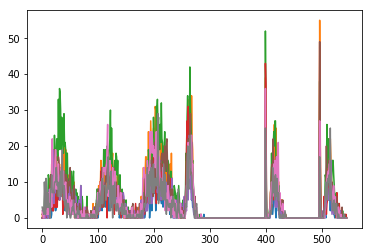

['haze',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'bare_ground']

In [140]:
xx = [0]+range(2,8)+[12] # плохие 600-4000
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


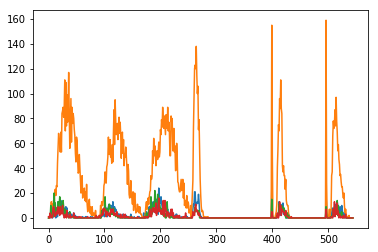

['slash_burn', 'partly_cloudy', 'blooming', 'selective_logging']

In [141]:
xx = [8,10,14,15] # среднии 100-400
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


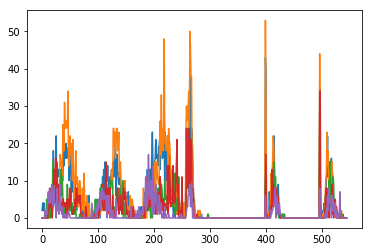

['primary', 'cloudy', 'conventional_mine', 'artisinal_mine', 'blow_down']

In [142]:
xx = [1,9,11,13,16] # отличные 0-100
plt.plot(bstga[:,xx]); plt.show();
[labels[x] for x in xx]

In [143]:
# Попытка посчитать уровень прохождения для каждого признака

In [144]:
ixx,iacc = [], []
for i in range(trY.shape[1]) :
    max, maxxx = 0.0, 0.0
    for xx in range(0,101) :
        tempYP = trYPP[:,i].copy(); #print(tempYP.mean())
        tempYP[tempYP<float(xx/100.0)] = 0
        tempYP[tempYP>0.0]   = 1
        temp = skm.accuracy_score(trY[:,i],tempYP)
        #print(float(xx/10.0),temp)
        if (temp>max) : 
            max = temp; maxxx = float(xx)
            temp = skm.confusion_matrix(trY[:,i],tempYP);
            minloss = temp[0][1]+temp[1][0]
    ixx.append(maxxx)
    tempYP = trYPP[:,i].copy(); #print(tempYP.mean())
    tempYP[tempYP<0.5]   = 0
    tempYP[tempYP>0.0]   = 1
    temp = skm.accuracy_score(trY[:,i],tempYP)
    minloss05 = skm.confusion_matrix(trY[:,i],tempYP);
    minloss05 = minloss05[0][1]+minloss05[1][0]
    iacc.append((maxxx,max,temp,minloss,minloss05))
ixx
#[ixx[xx] for xx in wr]

[44.0,
 55.0,
 46.0,
 56.0,
 39.0,
 39.0,
 43.0,
 36.0,
 18.0,
 51.0,
 7.0,
 3.0,
 26.0,
 9.0,
 21.0,
 20.0,
 15.0]

In [146]:
iacc

[(44.0, 0.97272659897724745, 0.97112082808369771, 1104, 1169),
 (55.0, 0.99456508312952396, 0.99372514143135948, 220, 254),
 (46.0, 0.93777020183304927, 0.93675733096173319, 2519, 2560),
 (56.0, 0.98307764519874508, 0.98196595765705674, 685, 730),
 (39.0, 0.93443513920798438, 0.93112478075051264, 2654, 2788),
 (39.0, 0.96642703624101389, 0.96324019862150745, 1359, 1488),
 (43.0, 0.9335951975098199, 0.93100125991254723, 2688, 2793),
 (36.0, 0.94288396452481538, 0.93297759331999308, 2312, 2713),
 (18.0, 1.0, 0.99997529583240696, 0, 1),
 (51.0, 0.9997529583240693, 0.99972825415647615, 10, 11),
 (7.0, 1.0, 1.0, 0, 0),
 (3.0, 1.0, 1.0, 0, 0),
 (26.0, 0.99416981644803482, 0.98982188295165396, 236, 412),
 (9.0, 1.0, 1.0, 0, 0),
 (21.0, 0.99814718743051956, 0.99528150398972304, 75, 191),
 (20.0, 0.99661552903974904, 0.99350280392302182, 137, 263),
 (15.0, 1.0, 0.99967884582129007, 0, 13)]

In [147]:
# Forming output dataset for predicting --> trOX, trOY
#del(trX)
#del(trY)

In [89]:
# Данные для объединения от jpg
trOX_TIF = np.load('../Work/test-data-XX'+str(binsDataTIF)+'.tif'+'.npy')
trOX_JPG = np.load('../Work/test-data-XX'+str(binsDataJPG)+'.jpg'+'.npy')
trOY_TIF = np.load('../Work/test-data-YY'+str(binsDataTIF)+'.tif'+'.npy')
trOY_JPG = np.load('../Work/test-data-YY'+str(binsDataJPG)+'.jpg'+'.npy')

In [150]:
trOX_TIF.shape, 578/6, 96*3

((61191, 578), 96, 288)

In [151]:
# Обрезка видимой части и использование только n, nvi, dwi
trOX_TIF = trOX_TIF[:,288:]
trOX_TIF.shape

(61191, 290)

In [154]:
# Аккуратно объединяем через индексы = имена файлов
dfOX_TIF = pd.DataFrame(trOX_TIF,index=trOY_TIF)
dfOX_JPG = pd.DataFrame(trOX_JPG,index=trOY_JPG)

dfOX = dfOX_JPG.join(dfOX_TIF,lsuffix='_l',rsuffix='_r')

dfOX.shape #, dfOX.columns,dfOX.head()

(61191, 545)

In [155]:
trOX = dfOX.values
trOY = dfOX.index.values
trOX.shape,trOY.shape,trOY[0:10]

((61191, 545),
 (61191,),
 array(['test_10002', 'test_10003', 'test_10004', 'test_10005',
        'test_10006', 'test_10007', 'test_10008', 'test_10009', 'test_1001',
        'test_10010'], dtype=object))

In [156]:
# Формирование результата
dtest  = xgb.DMatrix(trOX)

In [157]:
trP = []
for bstI in bstList :
    trP1 = bstI.predict(dtest);
    trP.append(trP1)
trP = np.array(trP).T
type(trP),trP.shape    

(numpy.ndarray, (61191, 17))

In [158]:
#np.save('../Work/test-data-RR'+str(binsData)+ttExt+'.npy',trP)

In [159]:
#trP = np.load('../Work/test-data-RR'+str(binsData)+ttExt+'.npy')
#trP.shape

In [160]:
wr = [labels.index(i) for i in weather_labels];
trM=np.array(ixx)/100.0 #np.array([0.5]*17);
#### Коэффициенты работают +0.01 к счету trM=np.array([0.5]*17);
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.55, 0.46, 2.0, 0.39, 0.39, 0.43, 0.36, 0.18, 2.0, 2.0, 0.03, 0.26, 0.09, 0.21, 0.2, 0.15]


In [161]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trA1 = [weather_labels[trP[i,wr].argmax()]]
    trA2 = [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])]
    trPP = trA1 + trA2;
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.    0.55  0.46  2.    0.39  0.39  0.43  0.36  0.18  2.    2.    0.03
  0.26  0.09  0.21  0.2   0.15] [  6.24508783e-02   2.45814770e-01   4.45817411e-02   4.16464716e-01
   5.03526151e-01   3.26644303e-03   1.00426078e-02   1.05248787e-03
   2.95093923e-06   5.92517912e-01   3.07402515e-05   1.12990097e-06
   1.18690729e-03   1.24388123e-06   1.84289253e-04   1.92705193e-04
   2.77233212e-05]


In [162]:
print(labels)
print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
[2.0, 0.55, 0.46, 2.0, 0.39, 0.39, 0.43, 0.36, 0.18, 2.0, 2.0, 0.03, 0.26, 0.09, 0.21, 0.2, 0.15]


In [163]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-03-05-40-12


In [730]:
trOX_TIF = np.load('../Work/test-data-XX'+str(binsData)+ttExt+'.npy')
trOX_JPG = np.load('../Work/test-data-XX'+'64'+'.jpg'+'.npy')
trOY_TIF = np.load('../Work/test-data-YY'+str(binsData)+ttExt+'.npy')
trOY_JPG = np.load('../Work/test-data-YY'+'64'+'.jpg'+'.npy')

In [752]:
dfOX_TIF = pd.DataFrame(trOX_TIF,index=trOY_TIF)
dfOX_JPG = pd.DataFrame(trOX_JPG,index=trOY_JPG)
dfOX_TIF.head(),dfOX_JPG.head()
dfOX = dfOX_JPG.join(dfOX_TIF,lsuffix='_l',rsuffix='_r')
dfOX.shape, dfOX.columns,dfOX.head()
dfOX.columns[range(190,250)+range(0,10)+range(450,462)]

Index([u'190_l', u'191_l',   u'0_r',   u'1_r',   u'2_r',   u'3_r',   u'4_r',
         u'5_r',   u'6_r',   u'7_r',   u'8_r',   u'9_r',  u'10_r',  u'11_r',
        u'12_r',  u'13_r',  u'14_r',  u'15_r',  u'16_r',  u'17_r',  u'18_r',
        u'19_r',  u'20_r',  u'21_r',  u'22_r',  u'23_r',  u'24_r',  u'25_r',
        u'26_r',  u'27_r',  u'28_r',  u'29_r',  u'30_r',  u'31_r',  u'32_r',
        u'33_r',  u'34_r',  u'35_r',  u'36_r',  u'37_r',  u'38_r',  u'39_r',
        u'40_r',  u'41_r',  u'42_r',  u'43_r',  u'44_r',  u'45_r',  u'46_r',
        u'47_r',  u'48_r',  u'49_r',  u'50_r',  u'51_r',  u'52_r',  u'53_r',
        u'54_r',  u'55_r',  u'56_r',  u'57_r',   u'0_l',   u'1_l',   u'2_l',
         u'3_l',   u'4_l',   u'5_l',   u'6_l',   u'7_l',   u'8_l',   u'9_l',
            258,      259,      260,      261,      262,      263,      264,
            265,      266,      267,      268,      269],
      dtype='object')

In [726]:
temp = pd.DataFrame(trOY_JPG==trOY_TIF,columns=['tf'])
print (temp.groupby('tf').count())
trOY_TIF[0:10],trOY_JPG[0:10]

Empty DataFrame
Columns: []
Index: [False]


(array(['test_28790', 'test_28791', 'test_28792', 'test_28793',
        'test_28794', 'test_28795', 'test_28796', 'test_28797',
        'test_28798', 'test_28799'], 
       dtype='|S10'),
 array(['test_10002', 'test_10003', 'test_10004', 'test_10005',
        'test_10006', 'test_10007', 'test_10008', 'test_10009', 'test_1001',
        'test_10010'], 
       dtype='|S10'))

In [710]:
trOXX = np.hstack([trOX_JPG,trOX_TIF])
trOX  = trOXX
print(trOX_JPG.shape,trOX_TIF.shape,trOX.shape)
#del trOXX,trOX_JPG,trOX_TIF
trOX.shape

(61191, 192) (61191, 450) (61191, 642)


(61191, 642)

In [715]:
192+450, 192/3, 450/6

(642, 64, 75)

In [721]:
trX_TIF = np.load('../Work/train-data-XX'+str(binsData)+ttExt+'.npy')
trX_JPG = np.load('../Work/train-data-XX'+'64'+'.jpg'+'.npy')
trY_TIF = np.load('../Work/train-data-YY'+str(binsData)+ttExt+'.npy')
trY_JPG = np.load('../Work/train-data-YY'+'64'+'.jpg'+'.npy')
print(trX_JPG.shape,trX_TIF.shape,trY_JPG.shape,trY_TIF.shape)

temp = pd.DataFrame((trY_JPG<>trY_TIF))
temp.head()
#temp.groupby('tf').count()

(40479, 192) (40479, 450) (40479, 17) (40479, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
